In [2]:
import pandas as pd
import numpy as np
from model import Network
import matplotlib.pyplot as plt


In [3]:
df_tmp = pd.read_csv("data/temperature-anomaly.csv")
df_tmp = df_tmp[df_tmp["Entity"] == "World"]
df_tmp = df_tmp[["Year", "Global"]][:-1]
df_tmp


,Year,Global
352,1850,-0.062523
353,1851,0.100442
354,1852,0.139907
355,1853,0.101611
356,1854,0.070376
...,...,...
522,2020,1.280204
523,2021,1.131273
524,2022,1.165803
525,2023,1.473764


In [4]:
df_ems = pd.read_csv("data/annual-co2-emissions-per-country.csv")
df_ems = df_ems[df_ems["Entity"] == "World"]
df_ems = df_ems[df_ems["Year"] >= 1850]
df_ems = df_ems[["Year","Emissions"]]
df_ems


,Year,Emissions
28937,1850,1.968476e+08
28938,1851,1.987785e+08
28939,1852,2.075951e+08
28940,1853,2.172370e+08
28941,1854,2.550386e+08
...,...,...
29107,2020,3.515823e+10
29108,2021,3.686686e+10
29109,2022,3.752777e+10
29110,2023,3.809404e+10


In [5]:
df_tmp = df_tmp.rename(columns={"Year": "year", "Global": "temp_anomaly"})
df_ems = df_ems.rename(columns={"Year": "year", "Emissions": "co2_emissions"})
df = pd.merge(df_tmp, df_ems, on="year", how="inner")
df


,year,temp_anomaly,co2_emissions
0,1850,-0.062523,1.968476e+08
1,1851,0.100442,1.987785e+08
2,1852,0.139907,2.075951e+08
3,1853,0.101611,2.172370e+08
4,1854,0.070376,2.550386e+08
...,...,...,...
170,2020,1.280204,3.515823e+10
171,2021,1.131273,3.686686e+10
172,2022,1.165803,3.752777e+10
173,2023,1.473764,3.809404e+10


In [6]:
df["cum_emissions"] = df["co2_emissions"].cumsum()
X = df[["cum_emissions"]]
y = df[["temp_anomaly"]]


x_min = X.min().values[0]
x_max = X.max().values[0]

y_min = y.min().values[0]
y_max = y.max().values[0]

Xn = (X - x_min) / (x_max - x_min)
yn = (y - y_min) / (y_max - y_min)

X_np = Xn.to_numpy()
y_np = yn.to_numpy()


In [17]:
model = Network([1, 32, 32, 1])

loss = model.train(X_np, y_np, 0.0001, 500000, None, False, 100)


Network initialized. Layer shapes: [((32, 1), (1, 32)), ((32, 32), (1, 32)), ((1, 32), (1, 1))]
Step: 100, Loss: 0.5644993811481207
Step: 200, Loss: 0.3818602475469864
Step: 300, Loss: 0.2684717272561601
Step: 400, Loss: 0.18959609439608782
Step: 500, Loss: 0.1345442496307821
Step: 600, Loss: 0.09620249540592911
Step: 700, Loss: 0.07030169051258878
Step: 800, Loss: 0.05187044862385758
Step: 900, Loss: 0.03845083963673413
Step: 1000, Loss: 0.0286790269880581
Step: 1100, Loss: 0.021563669958154456
Step: 1200, Loss: 0.016382953203465295
Step: 1300, Loss: 0.012610892199154802
Step: 1400, Loss: 0.009864878858499427
Step: 1500, Loss: 0.00786598258680713
Step: 1600, Loss: 0.006410968007018653
Step: 1700, Loss: 0.005351624892922909
Step: 1800, Loss: 0.004580511337610464
Step: 1900, Loss: 0.004019146103725743
Step: 2000, Loss: 0.003610440449755741
Step: 2100, Loss: 0.003312758530898276
Step: 2200, Loss: 0.003095970460640492
Step: 2300, Loss: 0.002938074386544975
Step: 2400, Loss: 0.002823040668

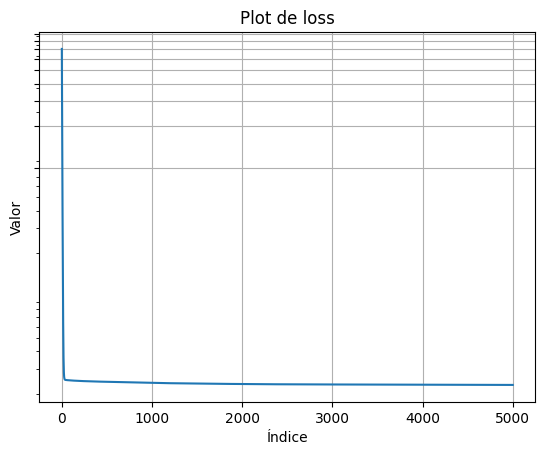

In [18]:
from matplotlib.ticker import MaxNLocator

x = list(range(len(loss)))

plt.plot(x, loss, marker="")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.title("Plot de loss")
plt.yscale("log")
plt.grid(True)
plt.gca().yaxis.set_major_locator(
    MaxNLocator(nbins=10, prune=None)
)
plt.show()


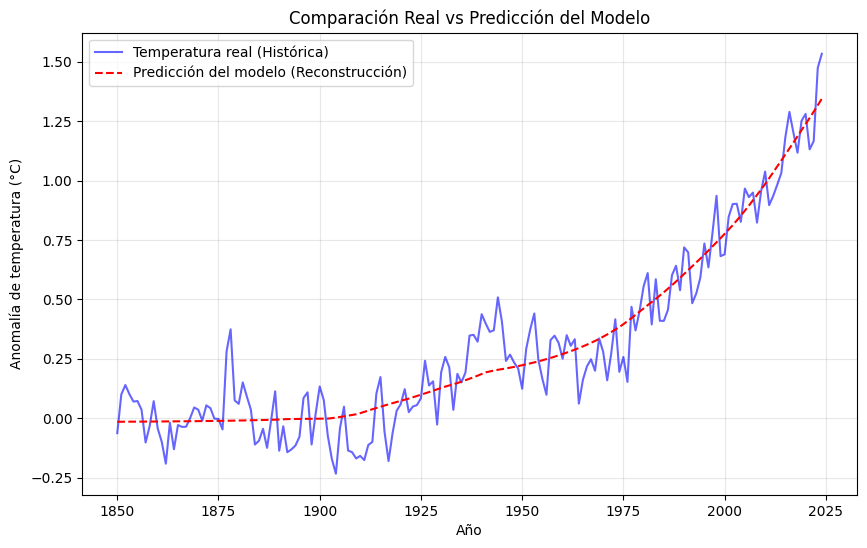

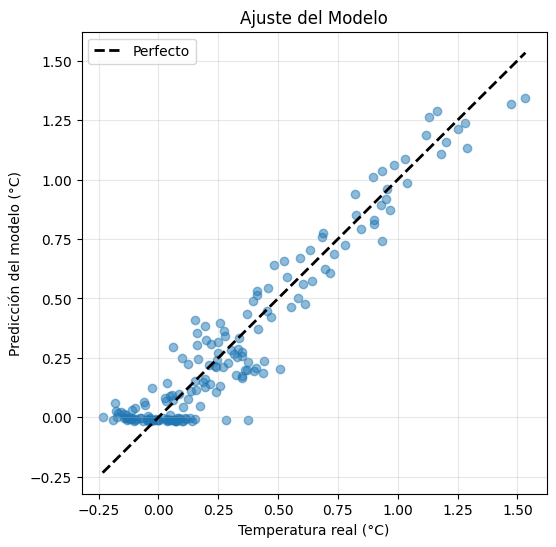

In [9]:
y_pred_norm = model.predict(X_np)[0]
y_min = df["temp_anomaly"].min()
y_max = df["temp_anomaly"].max()
y_pred = y_pred_norm * (y_max - y_min) + y_min
y_real = df["temp_anomaly"]

plt.figure(figsize=(10, 6))
plt.plot(
    df["year"], y_real, label="Temperatura real (Histórica)", color="blue", alpha=0.6
)
plt.plot(
    df["year"],
    y_pred.flatten(),
    label="Predicción del modelo (Reconstrucción)",
    color="red",
    linestyle="--",
)
plt.xlabel("Año")
plt.ylabel("Anomalía de temperatura (°C)")
plt.title("Comparación Real vs Predicción del Modelo")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(6, 6))
plt.scatter(y_real, y_pred.flatten(), alpha=0.5)
min_val = min(y_real.min(), y_pred.min())
max_val = max(y_real.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", lw=2, label="Perfecto")

plt.xlabel("Temperatura real (°C)")
plt.ylabel("Predicción del modelo (°C)")
plt.title("Ajuste del Modelo")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


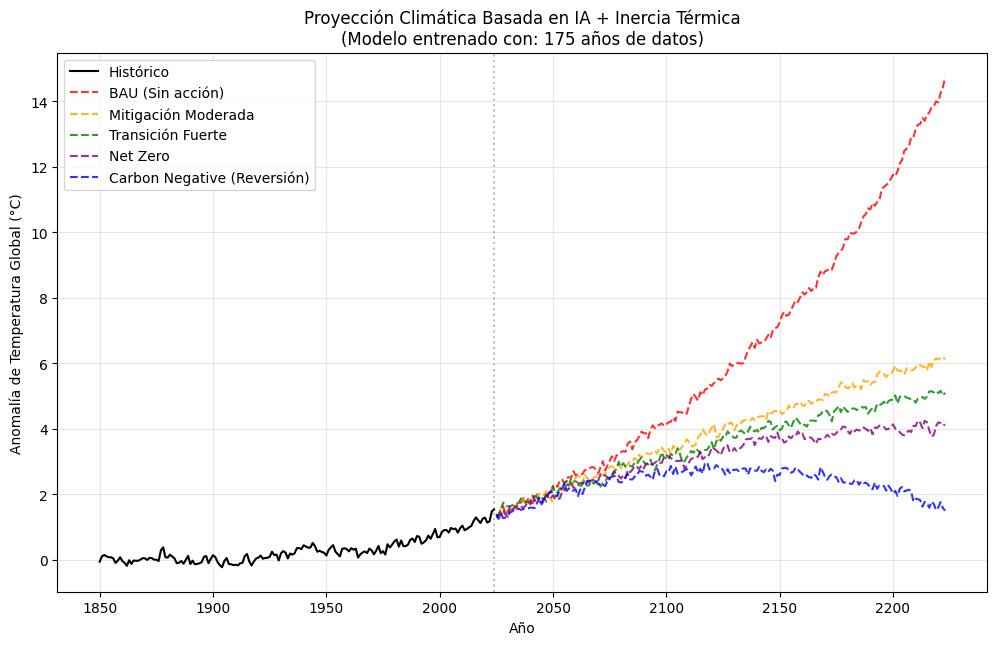

In [ ]:
def generate_climate_noise(n_years, sigma=0.1, rho=0.6):
    noise = np.zeros(n_years)
    noise[0] = np.random.normal(0, sigma)
    for t in range(1, n_years):

        noise[t] = rho * noise[t - 1] + np.random.normal(0, sigma * np.sqrt(1 - rho**2))
    return noise


years_hist = df["year"].to_numpy()
last_year = years_hist[-1]
last_added_emissions = df["cum_emissions"].iloc[-1]
years_future = np.arange(last_year + 1, last_year + 200)
n_future = len(years_future)
last_annual = 38.6e9


ems_bau = last_annual * (1.008 ** np.arange(1, n_future + 1))
ems_moderate = np.linspace(last_annual, 30e9, n_future)
ems_strong = np.linspace(last_annual, 15e9, n_future)
ems_netzero = np.linspace(last_annual, 0, n_future)
ems_negative = np.linspace(last_annual, -35e9, n_future)


load_bau = last_added_emissions + np.cumsum(ems_bau)
load_moderate = last_added_emissions + np.cumsum(ems_moderate)
load_strong = last_added_emissions + np.cumsum(ems_strong)
load_netzero = last_added_emissions + np.cumsum(ems_netzero)
load_negative = last_added_emissions + np.cumsum(ems_negative)


def predict_with_physics(load_emissions_scenario, inertia=0.15):
    Xf_norm = (load_emissions_scenario - x_min) / (x_max - x_min)
    Xf_norm = Xf_norm.reshape(-1, 1)
    y_raw_norm = model.predict(Xf_norm)[0]
    y_raw = y_raw_norm * (y_max - y_min) + y_min
    y_raw = y_raw.flatten()

    y_physics = np.zeros_like(y_raw)
    y_physics[0] = y_raw[0]

    for t in range(1, len(y_raw)):
        y_physics[t] = (1 - inertia) * y_raw[t] + inertia * y_physics[t - 1]

    climate_noise = generate_climate_noise(len(y_raw), sigma=0.11, rho=0.5)
    return y_physics + climate_noise


y_pred_bau = predict_with_physics(load_bau, inertia=0.2)
y_pred_mod = predict_with_physics(load_moderate, inertia=0.2)
y_pred_str = predict_with_physics(load_strong, inertia=0.2)
y_pred_zero = predict_with_physics(load_netzero, inertia=0.3)
y_pred_neg = predict_with_physics(load_negative, inertia=0.2)

plt.figure(figsize=(12, 7))
plt.plot(
    df["year"], df["temp_anomaly"], color="black", label="Histórico", linewidth=1.5
)


plt.plot(
    years_future,
    y_pred_bau,
    color="red",
    linestyle="--",
    alpha=0.8,
    label="BAU (Sin acción)",
)
plt.plot(
    years_future,
    y_pred_mod,
    color="orange",
    linestyle="--",
    alpha=0.8,
    label="Mitigación Moderada",
)
plt.plot(
    years_future,
    y_pred_str,
    color="green",
    linestyle="--",
    alpha=0.8,
    label="Transición Fuerte",
)
plt.plot(
    years_future,
    y_pred_zero,
    color="purple",
    linestyle="--",
    alpha=0.8,
    label="Net Zero",
)
plt.plot(
    years_future,
    y_pred_neg,
    color="blue",
    linestyle="--",
    alpha=0.8,
    label="Carbon Negative (Reversión)",
)

plt.axvline(x=last_year, color="gray", linestyle=":", alpha=0.5)
plt.title(
    f"Proyección Climática Basada en IA + Inercia Térmica\n(Modelo entrenado con: {len(df)} años de datos)"
)
plt.ylabel("Anomalía de Temperatura Global (°C)")
plt.xlabel("Año")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
